In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")


In [11]:
demographic_df = pd.read_csv("Demographic_monthly_update_data.csv")
enrolment_df   = pd.read_csv("Monthly_enrolment_data.csv")
update_df      = pd.read_csv("Monthly_update_data.csv")

print("Loaded successfully")


Loaded successfully


In [38]:
def parse_date(df):
    df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")
    df = df.dropna(subset=["date"])
    df["year_month"] = df["date"].dt.to_period("M").astype(str)
    return df

enrolment_df = parse_date(enrolment_df)
update_df = parse_date(update_df)
demographic_df = parse_date(demographic_df)


In [18]:
def clean_district(d):
    return (
        str(d).lower().strip()
        .replace(".", "")
        .replace("-", " ")
    )

for df in [enrolment_df, update_df, demographic_df]:
    df["district_clean"] = df["district"].apply(clean_district)



In [65]:
district_map = {
    "mumbai city": "mumbai",
    "mumbai suburban": "mumbai",
    "mumbai (sub urban)": "mumbai",
    "aurangabad": "chhatrapati sambhajinagar",
    "ahmed nagar": "ahilyanagar",
    "ahmednagar": "ahilyanagar",
    "washim *" : "washim",
    "raigarh": "raigad",
    "raigarh(mh)": "raigad",
    "gondiya": "gondia",
    "gondiya *": "gondia",
    "bid": "beed",
    "buldana": "buldhana",
    "osmanabad": "dharashiv",
    "nandurbar *": "nandurbar"
}

for df in [enrolment_df, update_df, demographic_df]:
    df["standard_district"] = df["district_clean"].replace(district_map)


In [66]:
enrol_age_cols = [c for c in enrolment_df.columns if c.startswith("age_")]

enrolment_df["new_enrolments"] = enrolment_df[enrol_age_cols].sum(axis=1)


In [67]:
bio_cols = [c for c in update_df.columns if c.startswith("bio_")]

update_df["total_updates"] = update_df[bio_cols].sum(axis=1)


In [68]:
print(enrolment_df.columns)


Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater', 'district_clean', 'standard_district',
       'new_enrolments', 'year_month'],
      dtype='object')


In [69]:
enrol_agg = enrolment_df.groupby(
    ["date", "state", "standard_district"],
    as_index=False
)["new_enrolments"].sum()

update_agg = update_df.groupby(
    ["date", "state", "standard_district"],
    as_index=False
)["total_updates"].sum()

demo_agg = demographic_df.groupby(
    ["date", "state", "standard_district"],
    as_index=False
)["total_demographic_updates"].sum()


In [70]:
demographic_cols = [c for c in demographic_df.columns if c.startswith("demo_")]

demographic_df["total_demographic_updates"] = demographic_df[demographic_cols].sum(axis=1)


In [71]:
final_df = (
    enrol_agg
    .merge(update_agg, on=["date", "state", "standard_district"], how="outer")
    .merge(demo_agg, on=["date", "state", "standard_district"], how="outer")
)

final_df.fillna(0, inplace=True)


In [72]:
final_df.sort_values("date", inplace=True)

final_df["enrolment_growth_pct"] = (
    final_df
    .groupby(["state", "standard_district"])["new_enrolments"]
    .pct_change()
    .fillna(0) * 100
)


In [73]:
final_df["update_zscore"] = stats.zscore(
    final_df["total_updates"].replace(0, np.nan),
    nan_policy="omit"
)

final_df["update_zscore"].fillna(0, inplace=True)


In [74]:
iso = IsolationForest(contamination=0.02, random_state=42)

final_df["anomaly_flag"] = iso.fit_predict(
    final_df[["new_enrolments", "total_updates"]]
)



In [75]:
top_district = final_df["standard_district"].value_counts().idxmax()

ts = (
    final_df[final_df["standard_district"] == top_district]
    .groupby("date")["new_enrolments"]
    .sum()
)

ts.index = pd.PeriodIndex(ts.index, freq="M")

model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=3)
print("Next 3 months forecast:")
print(forecast)


Next 3 months forecast:
2044-09    90.012960
2044-10    92.913171
2044-11    93.081352
Freq: M, Name: predicted_mean, dtype: float64


In [76]:
final_df["risk_score"] = (
    abs(final_df["update_zscore"]) +
    abs(final_df["enrolment_growth_pct"]) / 100
)

final_df["risk_level"] = pd.cut(
    final_df["risk_score"],
    bins=[-1, 0.5, 1.5, np.inf],
    labels=["Low", "Medium", "High"]
)



In [77]:
final_df.to_csv("uidai_final_analytics.csv", index=False)

final_df[final_df["anomaly_flag"] == -1] \
    .to_csv("uidai_anomalies.csv", index=False)

print("✅ Files exported successfully")


✅ Files exported successfully


In [78]:
final_df.sort_values("risk_score", ascending=False).head(10)


,date,state,standard_district,new_enrolments,total_updates,total_demographic_updates,enrolment_growth_pct,update_zscore,anomaly_flag,risk_score,risk_level
4082,2025-09-01,Maharashtra,pune,258.0,2618.0,1805.0,inf,0.285046,1,inf,High
6080,2025-10-24,Maharashtra,chhatrapati sambhajinagar,55.0,1402.0,776.0,inf,-0.043343,1,inf,High
6087,2025-10-24,Maharashtra,jalna,28.0,899.0,221.0,inf,-0.179182,1,inf,High
6086,2025-10-24,Maharashtra,jalgaon,32.0,1355.0,458.0,inf,-0.056036,1,inf,High
6085,2025-10-24,Maharashtra,hingoli,9.0,608.0,188.0,inf,-0.257768,1,inf,High
6084,2025-10-24,Maharashtra,gondia,15.0,518.0,130.0,inf,-0.282073,1,inf,High
6083,2025-10-24,Maharashtra,gadchiroli,12.0,317.0,107.0,inf,-0.336355,1,inf,High
6082,2025-10-24,Maharashtra,dhule,30.0,647.0,195.0,inf,-0.247236,1,inf,High
6081,2025-10-24,Maharashtra,dharashiv,25.0,395.0,129.0,inf,-0.315290,1,inf,High
7332,2025-11-25,Maharashtra,wardha,41.0,1242.0,451.0,inf,-0.086552,1,inf,High


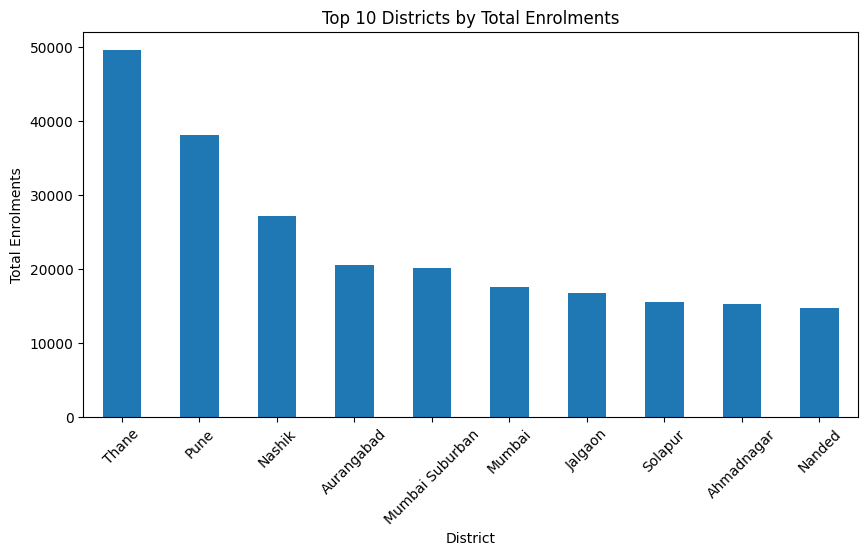

In [80]:
enrolment_df["total_enrolments"] = (
    enrolment_df["age_0_5"] + enrolment_df["age_5_17"] + enrolment_df["age_18_greater"]
)

top_enrolment = (
    enrolment_df.groupby("district")["total_enrolments"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_enrolment.plot(kind="bar")
plt.title("Top 10 Districts by Total Enrolments")
plt.ylabel("Total Enrolments")
plt.xlabel("District")
plt.xticks(rotation=45)
plt.show()


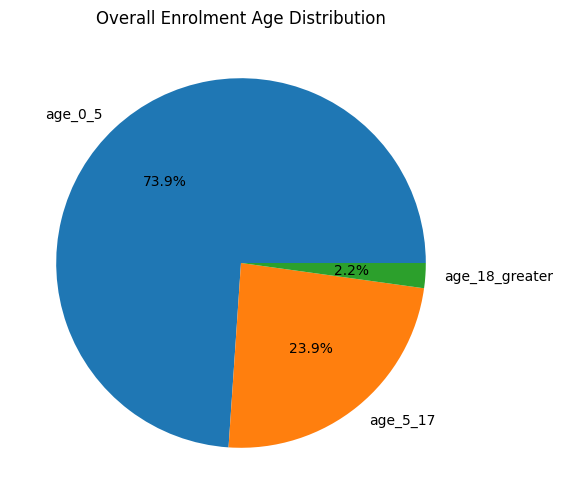

In [81]:
age_totals = enrolment_df[["age_0_5", "age_5_17", "age_18_greater"]].sum()

plt.figure(figsize=(6,6))
age_totals.plot(kind="pie", autopct="%1.1f%%")
plt.title("Overall Enrolment Age Distribution")
plt.ylabel("")
plt.show()


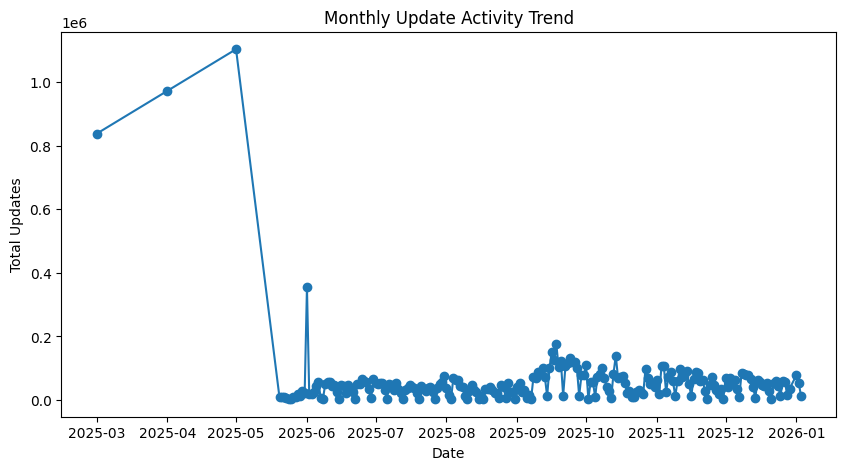

In [82]:
update_df["total_updates"] = (
    update_df["bio_age_5_17"] + update_df["bio_age_17_"]
)

monthly_updates = (
    update_df.groupby("date")["total_updates"]
    .sum()
    .sort_index()
)

plt.figure(figsize=(10,5))
plt.plot(monthly_updates.index, monthly_updates.values, marker="o")
plt.title("Monthly Update Activity Trend")
plt.xlabel("Date")
plt.ylabel("Total Updates")
plt.show()



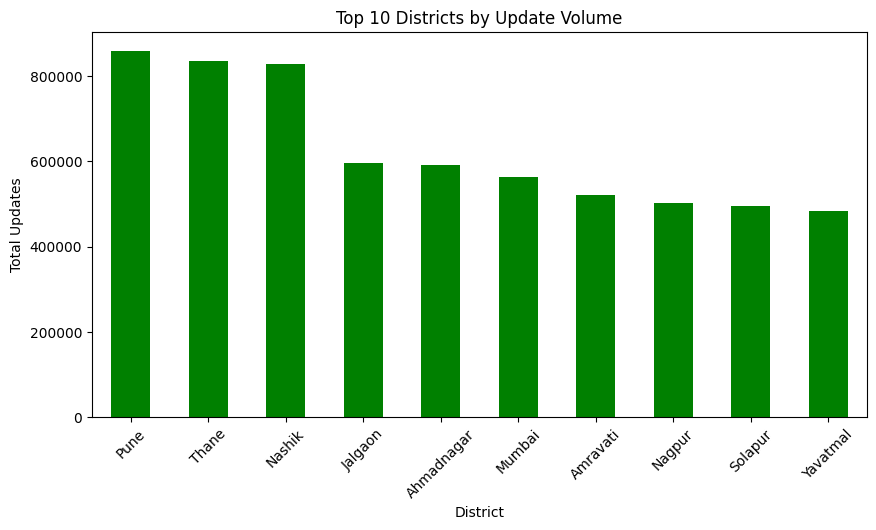

In [88]:
top_updates = (
    update_df.groupby("district")["total_updates"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_updates.plot(kind="bar", color="green")
plt.title("Top 10 Districts by Update Volume")
plt.ylabel("Total Updates")
plt.xlabel("District")
plt.xticks(rotation=45)
plt.show()


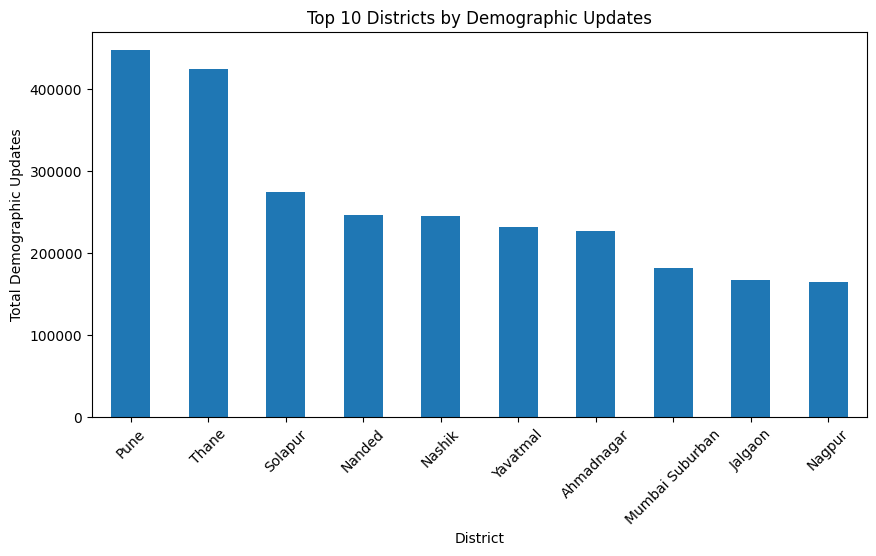

In [91]:
demographic_df["total_demo_updates"] = (
    demographic_df["demo_age_5_17"] + demographic_df["demo_age_17_"]
)

top_demo = (
    demographic_df.groupby("district")["total_demo_updates"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_demo.plot(kind="bar")
plt.title("Top 10 Districts by Demographic Updates")
plt.ylabel("Total Demographic Updates")
plt.xlabel("District")
plt.xticks(rotation=45)
plt.show()


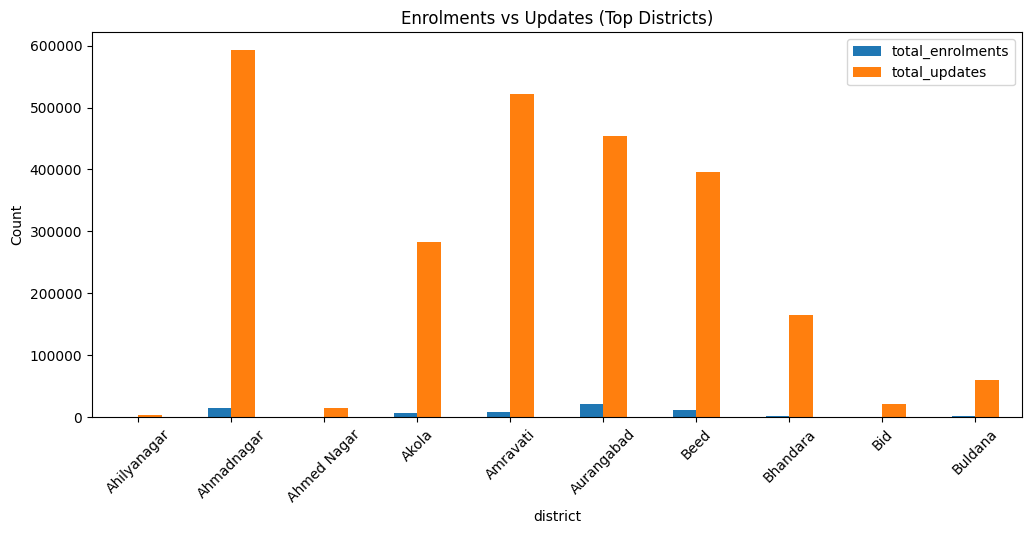

In [93]:
enrolment_summary = (
    enrolment_df.groupby("district")["total_enrolments"].sum()
)

update_summary = (
    update_df.groupby("district")["total_updates"].sum()
)

compare_df = pd.concat([enrolment_summary, update_summary], axis=1).dropna()
compare_df = compare_df.head(10)

compare_df.plot(kind="bar", figsize=(12,5))
plt.title("Enrolments vs Updates (Top Districts)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
